## Calculating the root zone fractions in each layer for CONUS2.0 

- This is a necessary input for evaptrans calcs
- Notes on evaptrans calcs from reed [here](https://docs.google.com/document/d/1TNZCPCYj1qsA4OlMlN3NB6XSOuV5fUmY4w4f6O7dm_8/edit?pli=1&tab=t.0):


### Overview of root zone fractions:
We need to take the land cover type for each cell and read in the A and B rooting depth parameter values.  Then we need to calculate the rooting depth as follows from pfsimulator/clm/drv_clmini.F90. See Reed's excel calculations [here](https://docs.google.com/spreadsheets/d/1upoZ9YMKSI5ltebsOxCjXSj8dNW4xdrNl5MDPWAKaKg/edit?gid=0#gid=0) for reference

```
do j = 1, nlevsoi-1
     clm%rootfr(j) = .5*( exp(-tile%roota*clm%zi(j-1))  &
                        + exp(-tile%rootb*clm%zi(j-1))  &
  enddo
  clm%rootfr(nlevsoi)=.5*( exp(-tile%roota*clm%zi(nlevsoi-1))&
                         + exp(-tile%rootb*clm%zi(nlevsoi-1)))

Where the interface depths Zi are
clm%zi(0)   = 0.                             !interface depths 
     do j = 1, nlevsoi-1
        clm%zi(j)= 0.5*(clm%z(j)+clm%z(j+1))     
     enddo
     clm%zi(nlevsoi) = clm%z(nlevsoi) + 0.5*clm%dz(nlevsoi) 
```

In [87]:
import pandas as pd
import os 
import numpy as np
import hf_hydrodata as hf
from parflow.tools.io import write_pfb
import matplotlib.pyplot as plt

In [58]:
# You need to register on https://hydrogen.princeton.edu/pin before you can use the hydrodata utilities
#email = input('Enter your hydrgen email address')
#pin = input('Enter your hydrogen PIN')
email='lecondon@email.arizona.edu'
pin=1234
#print('Registering ' + email + ' (PIN=' + pin + ') for HydroData download' ) #use lecondon@email.arizona.edu and 1234
hf.register_api_pin(email, pin)

## Calculate the root zone fractions in the CLM connected layers for every land cover type

In [ ]:
# Read in the root zone parameters by land cover type
param_dir='/Users/laura/Documents/Research/NAIRR/hydrogen-emulator-1ts/notebooks'

rz_param = pd.read_csv('./notebooks/land_cover_params.csv', index_col='Land Cover Type')
print(rz_param.columns)
dz_list = [0.1, 0.3, 0.6, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0, 200.0]
top_depth = np.append(0, np.cumsum(dz_list)) #Top depth of each layer
nz=len(dz_list)
nroot_lay = 4 #number of layers the root zone is distributed over

# Function to calculate the root zone fraction in any layer given the a and b parameters and the top and bottom depth of the layer
def calc_root_frac(row, top_depth, bottom_depth):
    #return row['roota']+row['rootb']
    return 0.5*(np.exp(-top_depth*row['roota'])+np.exp(-top_depth*row['rootb'])-np.exp(-bottom_depth*row['roota'])-np.exp(-bottom_depth*row['rootb']))

# Loop over the number of root layers calculate the root zone fraction for every land cover type and add to the dataframe
for layer in range(nroot_lay):
    laytop = top_depth[layer] #layer top (depth below surface)
    laybot = top_depth[(layer+1)] #Layer bottom (depth below surface)
    print('Calculating fractions for layer', layer, ":", laytop, '-', laybot)
    col_name=f'rfrac_layer{layer}'
    rz_param[col_name] = rz_param.apply(lambda x: calc_root_frac(x,laytop,laybot), axis=1)

#Write out a new dataframe with this information
fout=os.path.join(param_dir, 'root_zone_fractions.csv')
rz_param.to_csv(fout)

Index(['Landcover Name', 'roota', 'rootb'], dtype='object')
Calculating fractions for layer 0 : 0.0 - 0.1
Calculating fractions for layer 1 : 0.1 - 0.4
Calculating fractions for layer 2 : 0.4 - 1.0
Calculating fractions for layer 3 : 1.0 - 2.0


## Read in the CONUS land cover map 
# write out pfbs with root zone fractions for each layer
-4 pfbs one for each layer containing the root zone fracs. 
- Doing it this way will make it easier to do evap trans calcs just muliplying arrays

Step 1: Find a CONUS land cover map


In [ ]:
# Read in the land cover classifications
options = {
      "dataset":"conus2_domain", "grid": "conus2", "variable": "veg_type_IGBP"
}
landcover=hf.get_gridded_data(options)
landcover=landcover[0,:,:] # make it a 2D array

#Read in the mask
options = {
      "dataset":"conus2_domain", "grid": "conus2", "variable": "mask"
}
mask=hf.get_gridded_data(options)

#print(landcover.shape)
#print(np.max(landcover))
#print(np.min(landcover))
#print(np.sum(mask))

In [ ]:
# Write create an array and write out a pfb with the root fraction for layers 1:4 as well as the cumulative sum
for layer in range(nroot_lay):
    root_frac=np.copy(mask).astype(np.float64)
    col_name=f'rfrac_layer{layer}'
    print('layer', layer)
    for lc in np.arange(1,19):
        temp_frac = rz_param.loc[lc, col_name] #read the root zone frac for the given land cover type and layer
        root_frac[landcover==lc] = root_frac[landcover==lc] * temp_frac

    fout=os.path.join(param_dir, f'root_zone_frac_layer{layer}_{top_depth[layer]}-{top_depth[layer+1]}.pfb')
    write_pfb(fout, root_frac, dist=False)


layer 0
layer 1
layer 2
layer 3


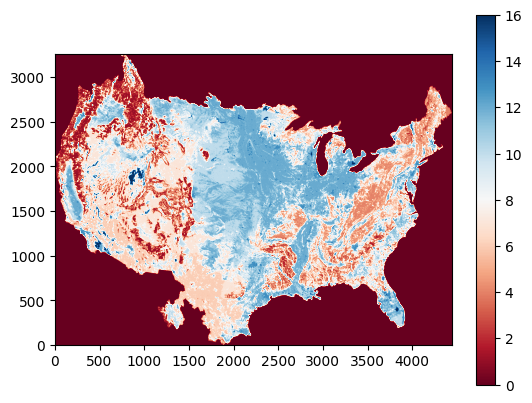

1.0
60


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
str= plt.imshow(landcover, cmap = "RdBu", origin='lower')
plt.colorbar(str, ax=plt.gca())
plt.show()



print(np.max(root_frac))
print(np.count_nonzero(root_frac == 1))

#print(np.count_nonzero(landcover == 0 & mask==1))

print(landcover[root_frac==1]) #where are these 60 cells is this just a missmatch of the landcover and the mask? 
print(mask[root_frac==1])

v